<a href="https://colab.research.google.com/github/profcarlos/SistemasInteligentes/blob/master/infrared_solar_modules_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Classifying InfraredSolarModules using Resnet in PyTorch**

In [ ]:
import os
import torch
import torchvision
import pandas as pd
import shutil
import re
import zipfile
import pandas as pd
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [ ]:
project_name = "infrared-solar-modules-cnn"

## **Repositório**

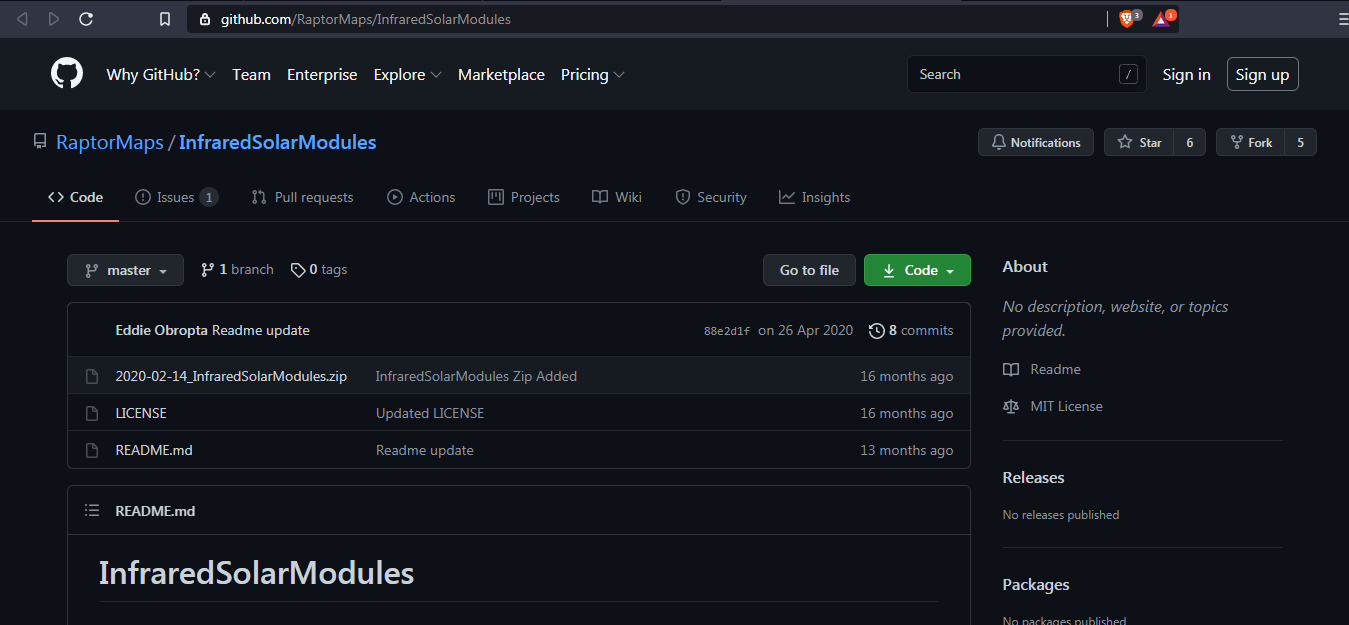

## **Preparing the InfraredSolarModues Dataset**

In [ ]:
# Download the dataset
dataset_url = "https://github.com/LucasGabrielCardoso/InfraredSolarModules/archive/refs/heads/master.zip"
download_url(dataset_url, ".")

In [ ]:
# Extract from dataset
with zipfile.ZipFile('./master.zip') as z:
    z.extractall()

with zipfile.ZipFile('./InfraredSolarModules-master/2020-02-14_InfraredSolarModules.zip') as z:
    z.extractall()

# with zipfile.ZipFile('./2020-02-14_InfraredSolarModules') as z:
#   z.extractall()

shutil.rmtree('./InfraredSolarModules-master')
shutil.rmtree('./__MACOSX')
os.remove('./master.zip')

In [ ]:
# Looking into the data directory
print(os.listdir("./InfraredSolarModules"))

['module_metadata.json', '.DS_Store', 'images']


In [ ]:
# Counting the number of images
print(len(os.listdir('./InfraredSolarModules/images')))

20000


In [ ]:
# Looking for class names
classes = pd.read_json('./InfraredSolarModules/module_metadata.json', orient='index')
classes.head()

,image_filepath,anomaly_class
13357,images/13357.jpg,No-Anomaly
13356,images/13356.jpg,No-Anomaly
19719,images/19719.jpg,No-Anomaly
11542,images/11542.jpg,No-Anomaly
11543,images/11543.jpg,No-Anomaly


In [ ]:
print(classes.anomaly_class.unique())

['No-Anomaly' 'Cell' 'Hot-Spot' 'Offline-Module' 'Vegetation' 'Diode'
 'Shadowing' 'Cracking' 'Diode-Multi' 'Hot-Spot-Multi' 'Cell-Multi'
 'Soiling']


In [ ]:
# Counting the number of classes
print(len(classes.anomaly_class.unique()))

12


In [ ]:
# Sorting images into nicer files
classes['image_file'] = classes['image_filepath'].str.extract(r'(\/.+)', expand=False)
classes.head()

,image_filepath,anomaly_class,image_file
13357,images/13357.jpg,No-Anomaly,/13357.jpg
13356,images/13356.jpg,No-Anomaly,/13356.jpg
19719,images/19719.jpg,No-Anomaly,/19719.jpg
11542,images/11542.jpg,No-Anomaly,/11542.jpg
11543,images/11543.jpg,No-Anomaly,/11543.jpg


In [ ]:
def sort_files(x):
  source = './InfraredSolarModules/'+x[0]
  destination = './InfraredSolarModules/images/'+x[1]

  if(not os.path.isdir(destination)):
    os.mkdir(destination)
  shutil.move(source, destination+x[2])

classes.apply(sort_files, axis=1)

13357    None
13356    None
19719    None
11542    None
11543    None
         ... 
8488     None
8489     None
7464     None
18065    None
13354    None
Length: 20000, dtype: object

In [ ]:
# Converting images in Tensors
datadir = './InfraredSolarModules/images'
dataset = ImageFolder(datadir, transform=tt.ToTensor())

In [ ]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 40, 24]) 0


tensor([[[0.7451, 0.7059, 0.6863,  ..., 0.8157, 0.8000, 0.7686],
         [0.7490, 0.7137, 0.6941,  ..., 0.8235, 0.8039, 0.7765],
         [0.7451, 0.7098, 0.6902,  ..., 0.8275, 0.8039, 0.7725],
         ...,
         [0.5176, 0.5333, 0.5529,  ..., 0.5765, 0.5412, 0.5098],
         [0.4588, 0.4745, 0.4941,  ..., 0.5020, 0.4745, 0.4510],
         [0.4196, 0.4353, 0.4510,  ..., 0.4627, 0.4392, 0.4235]],

        [[0.7451, 0.7059, 0.6863,  ..., 0.8157, 0.8000, 0.7686],
         [0.7490, 0.7137, 0.6941,  ..., 0.8235, 0.8039, 0.7765],
         [0.7451, 0.7098, 0.6902,  ..., 0.8275, 0.8039, 0.7725],
         ...,
         [0.5176, 0.5333, 0.5529,  ..., 0.5765, 0.5412, 0.5098],
         [0.4588, 0.4745, 0.4941,  ..., 0.5020, 0.4745, 0.4510],
         [0.4196, 0.4353, 0.4510,  ..., 0.4627, 0.4392, 0.4235]],

        [[0.7451, 0.7059, 0.6863,  ..., 0.8157, 0.8000, 0.7686],
         [0.7490, 0.7137, 0.6941,  ..., 0.8235, 0.8039, 0.7765],
         [0.7451, 0.7098, 0.6902,  ..., 0.8275, 0.8039, 0.

In [ ]:
def show_image(img, label):
  print('Label', dataset.classes[label], "("+str(label)+")")
  plt.imshow(img.permute(1,2,0));

Label Cell (0)


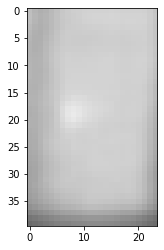

In [ ]:
show_image(*dataset[0])

Label No-Anomaly (7)


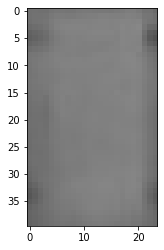

In [ ]:
show_image(*dataset[9000])

## **Training and Validation Datasets**

In [ ]:
random_seed = 42                      # If you didn't understend, it is a easter egg
torch.manual_seed(random_seed)

In [ ]:
val_size = 2000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(18000, 2000)

In [ ]:
batch_size = 128
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
def show_batch(dl):
  for img, label in dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(img, nrow=16).permute(1,2,0))
    break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


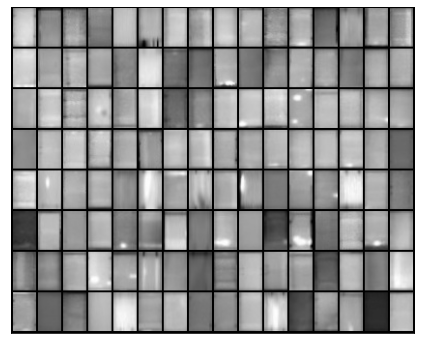

In [ ]:
show_batch(train_dl)

## **Defining the Model (Convolutional Neural Network)**

In [ ]:
def accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim=1)
  return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
class ImageClassificationBase(nn.Module):
  def training_step(self, batch):
    images, labels = batch
    out = self(images)                             # Generate Predictions
    loss = F.cross_entropy(out, labels)            # Calculate loss
    return loss

  def validatioin_step(self, batch):
    images, labels = batch
    out = self(images)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)                     # Calculate accuracy
    return {'val_loss': loss.detach(), 'val_acc': acc}

  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_losses = torch.stack(batch_losses).mean() # Combining losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_accs = torch.stack(batch_accs).mean()      # Combining accuracies
    return {'val_loss': epoch_losses.item(), 'val_acc': epoch_accs.item()}

  def epoch_end(self, epoch, result):
    print("Epoch [{}], train_loss: [{:.4f}], val_loss: [{:.4f}], val_acc: [{:.4f}]".format(epoch, 
                                                                        result['train_loss'],
                                                                        result['val_loss'],
                                                                        result['val_acc'])) 

In [ ]:
class InfraredSolarModulesCnnModel(ImageClassificationBase):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),                                        # output: 64x16x16

        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),                                        # output: 128x8x8

        nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2,2),                                            # output 256,4,4

        nn.Flatten(),
        nn.Linear(256*5*3, 1024),
        nn.ReLU(),
        nn.Linear(1024, 512),
        nn.ReLU(),
        nn.Linear(512, 12)
        )
    
  def forward(self, xb):
    return self.network(xb)

In [ ]:
model = InfraredSolarModulesCnnModel()
model

InfraredSolarModulesCnnModel(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Flatten(start_dim=1, end_dim=-1)
    (16): Linear(in_features=3840, out_features=1024, bias=True)
    (17): ReLU()
    (18): L

In [ ]:
# Verifying that the model produced the expected output on a batch of training data.
for images, labels in train_dl:
  print('images.shape: ', images.shape)
  out = model(images)
  print('out.shape: ', out.shape)
  print('out[0]: ', out[0])
  break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


images.shape:  torch.Size([128, 3, 40, 24])
out.shape:  torch.Size([128, 12])
out[0]:  tensor([ 0.0237,  0.0208,  0.0144, -0.0066, -0.0101,  0.0169, -0.0441, -0.0296,
        -0.0036, -0.0278,  0.0480, -0.0199], grad_fn=<SelectBackward>)


## **Using GPU with PyToch**

In [ ]:
def get_default_device():
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    return len(self.dl)

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device)

## **Training the Model**

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
  model.eval()
  outputs = [model.validatioin_step(batch) for batch in val_loader]
  return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
  history = []
  optimizer = opt_func(model.parameters(), lr)
  for epoch in range(epochs):
    # Training Phase
    model.train()
    train_losses = []
    for batch in train_loader:
      loss = model.training_step(batch)
      train_losses.append(loss)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    
    # Validation phase
    result = evaluate(model, val_loader)
    result['train_loss'] = torch.stack(train_losses).mean().item()
    model.epoch_end(epoch, result)
    history.append(result)
  return history

In [ ]:
evaluate(model, val_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


{'val_acc': 0.010216346010565758, 'val_loss': 2.497194766998291}

In [ ]:
num_epochs = 10
opt_func = torch.optim.Adam
lr = 0.001

In [ ]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [0], train_loss: [1.7746], val_loss: [1.7433], val_acc: [0.4882]
Epoch [1], train_loss: [1.7003], val_loss: [1.5239], val_acc: [0.5472]
Epoch [2], train_loss: [1.4043], val_loss: [1.1909], val_acc: [0.6422]
Epoch [3], train_loss: [1.0748], val_loss: [0.9758], val_acc: [0.6865]
Epoch [4], train_loss: [0.9270], val_loss: [0.8540], val_acc: [0.7269]
Epoch [5], train_loss: [0.8302], val_loss: [0.8375], val_acc: [0.7222]
Epoch [6], train_loss: [0.7557], val_loss: [0.7683], val_acc: [0.7562]
Epoch [7], train_loss: [0.7015], val_loss: [0.7491], val_acc: [0.7619]
Epoch [8], train_loss: [0.6265], val_loss: [0.7211], val_acc: [0.7702]
Epoch [9], train_loss: [0.5782], val_loss: [0.7322], val_acc: [0.7705]
